In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import sys
sys.path.append(os.path.abspath('..'))
import random

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection

from IPython.display import display, Markdown, Latex

import torch
from torch import nn
import torch.nn.functional as F

from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping

In [3]:
torch.manual_seed(33)

In [4]:
from simple_relational_reasoning.datagen import *
from simple_relational_reasoning.datagen import IdenticalObjectsRelation
from simple_relational_reasoning.models import MLPModel, RelationNetModel

In [5]:
from collections import namedtuple
VisualizationDefinition = namedtuple('VisualizationDefinition', ('name', 'patch_class', 'offset', 'patch_args'))
VISUALIZATION_DEFINITIONS = (
    VisualizationDefinition('square', mpatches.Rectangle, np.array([0, 0]), (10, 10)),
    VisualizationDefinition('circle', mpatches.Circle, np.array([5, 5]), (5, )),
    VisualizationDefinition('triangle', mpatches.RegularPolygon, np.array([5, 5]), (3, 6)),
    VisualizationDefinition('pentagon', mpatches.RegularPolygon, np.array([5, 5]), (5, 5.5)),
)


DEFAULT_PATCH_KWARGS = dict(ec='none')
DEFAULT_SCALE = 10


def object_to_patch(object_tensor, field_slices, 
                    x_field='x', y_field='y', 
                    color_field='color', shape_field='shape',
                    scale=DEFAULT_SCALE, additional_patch_kwargs=None, 
                    visualization_definitions=VISUALIZATION_DEFINITIONS):
    
    patch_kwargs = DEFAULT_PATCH_KWARGS.copy()
    if additional_patch_kwargs is not None: 
        patch_kwargs.update(additional_patch_kwargs)
    
    x = int(object_tensor[field_slices[x_field]])
    y = int(object_tensor[field_slices[y_field]])
    position = np.array([x, y]) * scale
    shape_index = int(torch.nonzero(object_tensor[field_slices[shape_field]]).squeeze())
    color_index = int(torch.nonzero(object_tensor[field_slices[color_field]]).squeeze())
    
    vis_def = visualization_definitions[shape_index]
    patch = vis_def.patch_class(position + vis_def.offset, *vis_def.patch_args,
                                **patch_kwargs)
    
    return patch, color_index


def visualize_objects(objects, object_generator, ax=None, x_field='x',
                      y_field='y', color_field='color', shape_field='shape',
                      scale=DEFAULT_SCALE, figsize=(6, 6), bg_color='black', 
                      additional_patch_kwargs=None, 
                      visualization_definitions=VISUALIZATION_DEFINITIONS,
                      cmap=plt.cm.tab10, clim=(0, 10)):
   
    call_show = False
    if ax is None:
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(1, 1, 1)
        call_show = True

    x_gen = object_generator.field_generators[x_field]
    plt.xlim(x_gen.min_coord * scale, x_gen.max_coord * scale)
    y_gen = object_generator.field_generators[y_field]
    plt.ylim(y_gen.min_coord * scale, y_gen.max_coord * scale)
    ax.set_facecolor(bg_color)
    
    patches, colors = zip(*[object_to_patch(objects[i], object_generator.field_slices, 
                                            x_field=x_field, y_field=y_field, 
                                            color_field=color_field, shape_field=shape_field, 
                                            scale=scale, additional_patch_kwargs=additional_patch_kwargs,
                                            visualization_definitions=visualization_definitions)
                            for i in range(objects.shape[0])])
    
    collection = PatchCollection(patches, cmap=cmap) 
    collection.set_array(np.array(colors)) 
    collection.set_clim(*clim)
    ax.add_collection(collection)
    
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    
    if call_show:
        plt.show()
    

In [6]:
cfgs = ( 
    object_gen.FieldConfig('x', 'int_position', dict(max_coord=20)), 
    object_gen.FieldConfig('y', 'int_position', dict(max_coord=20)), 
    object_gen.FieldConfig('color', 'one_hot', dict(n_types=4)),
    object_gen.FieldConfig('shape', 'one_hot', dict(n_types=4))
)

# gen = object_gen.ObjectGenerator(4, cfgs, 
gen = object_gen.SmartBalancedBatchObjectGenerator(4, cfgs, 
#                                                    MultipleDAdjacentRelation, 
                                                   ColorAboveColorRelation,
#                                                    ObjectCountRelation,
                                                   object_dtype=torch.float, label_dtype=torch.long,
                                                   max_recursion_depth=100
                                                  )

X, y = gen(1024)
X.shape, y.shape, y.sum()

(torch.Size([1024, 4, 10]), torch.Size([1024]), tensor(512))

# MultipleDAdjacentRelation

Are any two objects adjacent (L1 distance of 1)?

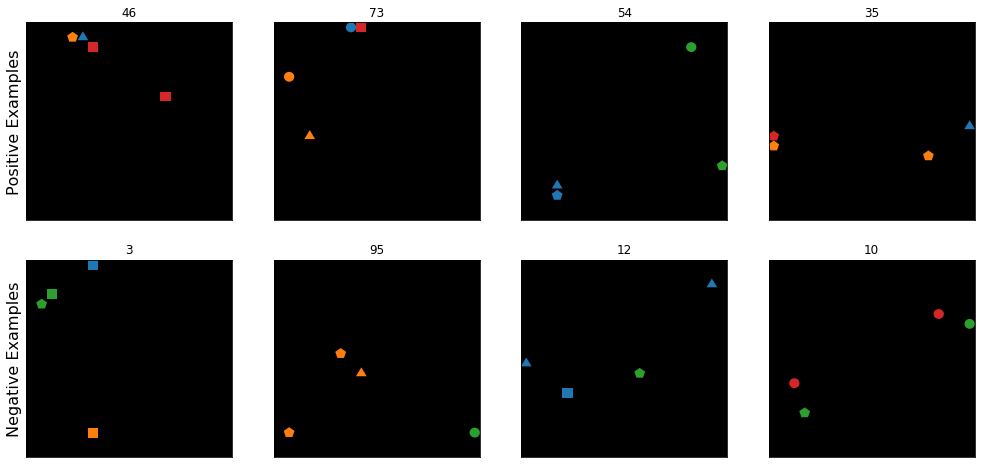

------

# ColorAboveColorRelation

Is there a blue object above (or at the same height of) all orange objects?

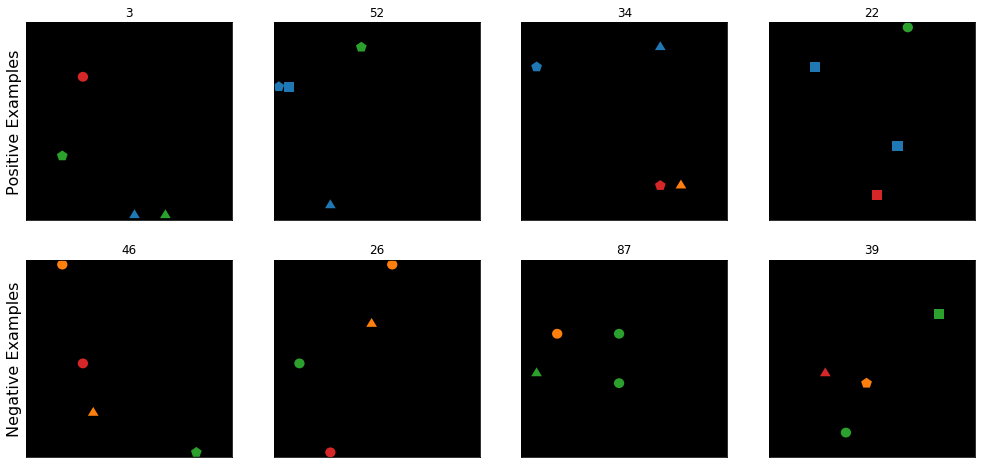

------

# ObjectCountRelation

Are there more blue objects than squares?

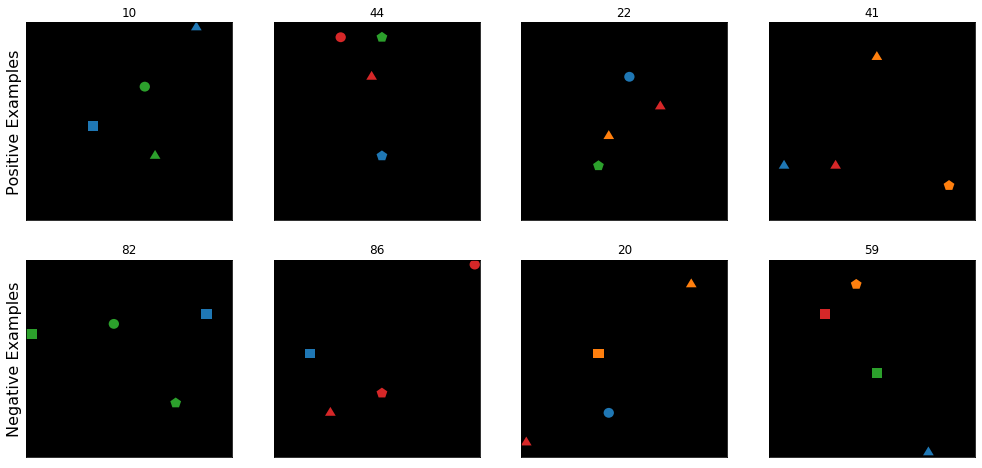

------

In [7]:
IMAGES_PER_LABEL = 4
N_OBJECTS = 4
FONTSIZE = 16

descriptions = {
    MultipleDAdjacentRelation: 'Are any two objects adjacent (L1 distance of 1)?',
    ColorAboveColorRelation: 'Is there a blue object above (or at the same height of) all orange objects?',
    ObjectCountRelation: 'Are there more blue objects than squares?',
    IdenticalObjectsRelation: 'Are any two objects identical (in shape and color)?'
}

X = {}
y = {}

for relation_class in (MultipleDAdjacentRelation, ColorAboveColorRelation, 
                       ObjectCountRelation, 
#                        IdenticalObjectsRelation
                      ):
    fig = plt.figure(figsize=(4 * IMAGES_PER_LABEL + 1, 8))
    display(Markdown(f'# {relation_class.__name__}'))
    display(Markdown(descriptions[relation_class]))
    
    gen = object_gen.SmartBalancedBatchObjectGenerator(4, cfgs, relation_class,
                                                       object_dtype=torch.float, label_dtype=torch.long,
                                                       max_recursion_depth=100
                                                      )

    X[relation_class], y[relation_class] = gen(100)
    y[relation_class] = y[relation_class].bool()
    positive_indices = np.random.choice(torch.nonzero(y[relation_class]).squeeze(), size=4, replace=False)
    negative_indices = np.random.choice(torch.nonzero(~y[relation_class]).squeeze(), size=4, replace=False)
    
    for i, idx in enumerate(positive_indices):
        ax = plt.subplot(2, IMAGES_PER_LABEL, i + 1)
        if i == 0:
            ax.set_ylabel('Positive Examples', fontsize=FONTSIZE)
            
        visualize_objects(X[relation_class][idx], gen, ax)
        ax.set_title(idx)

        
    for i, idx in enumerate(negative_indices):
        ax = plt.subplot(2, IMAGES_PER_LABEL, i + IMAGES_PER_LABEL + 1)
        if i == 0:
            ax.set_ylabel('Negative Examples', fontsize=FONTSIZE)
            
        visualize_objects(X[relation_class][idx], gen, ax)
        ax.set_title(idx)
        
    plt.show()
    display(Markdown(f'------'))

# Dataset generation details

* We generate a dataset of $M$ images, each with $N$ objects to be balanced with respect to a particular relation.
* Each relation class (see the implementations in `object_relations.py`) knows how to convert a negative example to a positive, but not vice versa. That is, we can change a collections of objects where a relation doesn't hold to one where it does.
* First, we sample $M$ images randomly. 
* If more than $M / 2$ are positive (with respect to the given relation), we resample all of the positive ones, repeating until at least $M / 2$ are negative.
* We now have $M_{neg} > M / 2$ negative images. We convert $M_{neg} - M / 2$ of them to be positive, guaranteeing our dataset is balanced 50/50.
* The logic above is implemented in the `SmartBalancedBatchObjectGenerator` class in `object_gen.py`.
